In [1]:
import datetime as dt
import pandas as pd
#!pip install yfinance
import yfinance as yf

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import to_date
from pyspark.ml.evaluation import RegressionEvaluator


In [3]:
# SparkSession başlatma
spark = SparkSession.builder.appName("NVDA Price Prediction").getOrCreate()

24/03/29 22:46:38 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
# Veriyi yükleme ve DataFrame oluşturma
data = spark.read.csv("file:///home/hduser/Desktop/NVDA/NVDA_histrical_data.csv", header=True, inferSchema=True)

# 'Date' sütununu tarih tipine dönüştürme 
data = data.withColumn("Date", to_date(data["Date"]))

In [5]:
data.show(5)

+----------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+
|      Date|               Open|               High|                Low|              Close|          Adj Close|  Volume|
+----------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+
|1999-03-22| 0.4466150104999542|0.44791701436042786|0.42447900772094727|0.42447900772094727| 0.3893755376338959| 3667200|
|1999-03-23|0.42708298563957214|0.42708298563957214|           0.390625| 0.3984380066394806| 0.3654879927635193|16396800|
|1999-03-24|0.39583298563957214| 0.3984380066394806|0.38020798563957214|0.39583298563957214| 0.3630985617637634| 6086400|
|1999-03-25| 0.3945310115814209|0.41666701436042786|0.39322900772094727|0.40104201436042786|0.36787667870521545| 4032000|
|1999-03-26|            0.40625|             0.4375|            0.40625|0.43619799613952637|0.40012532472610474| 8827200|
+----------+------------

In [6]:
spark.createDataFrame(data.tail(5)).show()

+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+
|      Date|             Open|             High|              Low|            Close|        Adj Close|  Volume|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+
|2024-03-15|869.2999877929688|895.4600219726562|862.5700073242188|878.3699951171875|878.3699951171875|64019300|
|2024-03-18|903.8800048828125|924.0499877929688|870.8499755859375|884.5499877929688|884.5499877929688|66897600|
|2024-03-19|            867.0|905.4400024414062|850.0999755859375|  893.97998046875|  893.97998046875|67217100|
|2024-03-20| 897.969970703125|904.0999755859375|  882.22998046875| 903.719970703125| 903.719970703125|47906300|
|2024-03-21|            923.0|  926.47998046875|904.0499877929688|914.3499755859375|914.3499755859375|48037200|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--

In [7]:
# 'Close' dışındaki tüm sütunları at
df_org = data.select("Date", "Close")

# İlk 5 satırı göstermek için
df_org.show(5)


+----------+-------------------+
|      Date|              Close|
+----------+-------------------+
|1999-03-22|0.42447900772094727|
|1999-03-23| 0.3984380066394806|
|1999-03-24|0.39583298563957214|
|1999-03-25|0.40104201436042786|
|1999-03-26|0.43619799613952637|
+----------+-------------------+
only showing top 5 rows



In [8]:
df = df_org

In [9]:
from pyspark.sql.functions import col, count, when

# Her bir sütun için eksik değer sayısını hesaplama
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+----+-----+
|Date|Close|
+----+-----+
|   0|    0|
+----+-----+



In [10]:
# 'Close' sütunu ve 'Date' sütunu ile sınırlı DataFrame'i CSV olarak kaydet
#df.write.csv("file:///home/hduser/Desktop/NVDA/NVDA.csv", header=True)


Uyarıları tamamen kapatmanın bir yolu olmasa da, günlükleri daha az ayrıntılı hale getirerek uyarıların gösterilmesini azaltabilirsiniz. Bu, Spark'ın günlük seviyesini ayarlayarak yapılabilir. Örneğin, günlük seviyesini "ERROR" olarak ayarlamak yalnızca hata mesajlarının gösterilmesini sağlayacaktır.

In [11]:
spark.sparkContext.setLogLevel("ERROR")

1. Veri Setinin Yüklenmesi ve Öznitelik Oluşturma

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag,col, to_date, dayofweek
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
# Spark oturumunu başlatma
spark = SparkSession.builder.appName("Stock Price Forecasting").getOrCreate()

# Gecikmeli öznitelikler ekleyin
for i in range(1, 6):
    df = df.withColumn(f"lag_{i}", lag(col("Close"), i).over(Window.orderBy("Date")))

# Haftanın günü gibi tarih özniteliklerini ekleyin
df = df.withColumn("DayOfWeek", dayofweek(col("Date")))

# Eğitim için kullanılacak özniteliklerin listesini oluştur
input_cols = [f"lag_{i}" for i in range(1, 6)] + ['DayOfWeek']

In [13]:
from pyspark.sql import functions as F

for i in range(1, 6):
    # 'lag' sütunlarını mevcut 'Close' değeriyle doldurun
    df = df.withColumn(f"lag_{i}", F.coalesce(df[f"lag_{i}"], df["Close"]))

In [14]:
#df.show(6)

In [15]:
from pyspark.sql.functions import dayofweek
# 'DayOfWeek' sütunu için eksik değerleri doldurun
#df = df.withColumn('DayOfWeek', dayofweek(df['Date']))
# 'DayOfWeek' sütunu için `null` değerleri kontrol edin ve doldurun
#df = df.na.fill({'DayOfWeek': 0})

# VectorAssembler'ı tekrar çalıştırın
vectorAssembler = VectorAssembler(inputCols=input_cols, outputCol='features')
df = vectorAssembler.transform(df)

# Veri setini eğitim ve test olarak ayırma
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


2. Model Eğitimi ve Katsayıların Gözlemlenmesi

In [16]:
from pyspark.ml.regression import LinearRegression

# Modeli tanımla ve eğit
lr = LinearRegression(featuresCol="features", labelCol="Close")
model = lr.fit(train_df)

# Eğitim ve test setleri üzerinde tahminler yap
train_predictions = model.transform(train_df)
test_predictions = model.transform(test_df)

# Model katsayılarını ve intercept değerini yazdır
print("Intercept:", model.intercept)
print("Coefficients:")
for i, coeff in enumerate(model.coefficients):
    print(f"lag_{i+1} coefficient: {coeff}")


Intercept: 0.04988244110402498
Coefficients:
lag_1 coefficient: 0.9337373195024947
lag_2 coefficient: -0.04444383555935839
lag_3 coefficient: 0.13583450907517358
lag_4 coefficient: -0.042829205807827314
lag_5 coefficient: 0.022714581792605455
lag_6 coefficient: -0.03340973729783707


3. Model Değerlendirme (RMSE ve MSE)

In [17]:
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE ve MSE değerlendirici tanımla ve hesapla
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close")

train_rmse = evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})
test_rmse = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
train_mse = evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
test_mse = evaluator.evaluate(test_predictions, {evaluator.metricName: "mse"})

print(f"Train RMSE: {train_rmse}, Train MSE: {train_mse}")
print(f"Test RMSE: {test_rmse}, Test MSE: {test_mse}")


Train RMSE: 3.81371978892459, Train MSE: 14.544458628435018
Test RMSE: 3.0538706461634777, Test MSE: 9.326125923498937


4. Gelecekteki 5 Gün İçin Tahminlerin Yapılması

In [18]:
import datetime as dt

last_row = train_df.orderBy(F.desc("Date")).first()
today_date = last_row["Date"]
#end = dt.datetime.now()
end = dt.datetime.now().date()
# Hafta içi ve toplam günlerin sayısını saklamak için bir değişken tanımla 
# Bu degiskenlere gelecek degerler bir gun oncenin olacagi icin -1'den baslatiyoruz
weekdays_count = -1
totol_days = -1
# Tarih aralığını döngüye alarak her gün için hafta içi olup olmadığını kontrol et
current_date = today_date
while current_date < end:
    totol_days += 1
    # Eğer gün hafta içi ise, weekdays_count değişkenini artır
    if current_date.weekday() < 5:  # Pazartesi (0) - Cuma (4)
        weekdays_count += 1
    # Bir sonraki günü al
    current_date += dt.timedelta(days=1)

# Hafta içi günlerin sayısını yazdır
print("Hafta içi günlerin toplam sayısı:", weekdays_count)
print("Toplam geçen gün sayısı:", totol_days)

Hafta içi günlerin toplam sayısı: 5
Toplam geçen gün sayısı: 7


In [19]:
from datetime import datetime, timedelta
# Gelecek tarihler için bir liste oluşturun, hafta sonlarını atlayın
future_dates = []
for i in range(1, totol_days+1):
    next_day = today_date + timedelta(days=i)
    if next_day.weekday() < 5:  # 0: Pazartesi, ..., 4: Cuma
        future_dates.append(next_day)
future_dates

[datetime.date(2024, 3, 22),
 datetime.date(2024, 3, 25),
 datetime.date(2024, 3, 26),
 datetime.date(2024, 3, 27),
 datetime.date(2024, 3, 28)]

In [20]:
# Modelin en son tahminlerinden ve bilinen değerlerden yeni gecikmeli öznitelikler yaratma
last_known_values = [last_row["Close"]] + [last_row[f"lag_{i}"] for i in range(1, 5)]

In [21]:
from pyspark.sql.functions import lit, array
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import to_date, max
from datetime import datetime, timedelta

# Modeli ve son bilinen verileri yükleyin
#trained_model = # Eğitilmiş modelinizin yüklendiği yer
#last_known_values = # Son bilinen lag ve close değerleri


# Tahmin yapmak istediğiniz gün sayısını belirleyin
future_days = len(future_dates)  # Örneğin, future_dates uzunlugu kadar tahmin etmek istiyorsanız

# Veri setindeki en son tarihi al
last_date_row = df.select(max(to_date("Date"))).collect()
current_date = last_date_row[0][0]
#current_date = datetime.now()  # Mevcut tarihi kullanarak tahminler yapın

# Gelecek tarihler için boş bir DataFrame oluşturun
#future_dates = [current_date + timedelta(days=i) for i in range(1, future_days + 1)]
future_predictions = []


# Örnek olarak, eğer modeliniz 5 gecikme özelliği kullanıyorsa (lag_1, lag_2, ... lag_5),
# ve last_known_values son bilinen 'Close' değeri ve 5 gecikme özelliğini içeriyorsa:
lag_features = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

# Bu değerleri kullanarak yeni özellikler vektörünü oluşturun
#new_features = [last_known_values[i] for i in lag_features]

# Döngü ile tahminleri yapın
for future_date in future_dates:
    # Yeni özellikler vektörünü oluşturun
    new_features = last_known_values[-len(lag_features):] + [last_known_values[0]]
    new_features_vector = Vectors.dense(new_features)
    
    # Yeni veri setini oluşturun ve tahmin yapın
    df_to_predict = spark.createDataFrame([(future_date, new_features_vector)], ["Date", "features"])
    prediction = model.transform(df_to_predict)
    
    # Tahmin edilen değeri alın ve sonuç listesine ekleyin
    predicted_close = prediction.select("prediction").collect()[0]["prediction"]
    future_predictions.append((future_date, predicted_close))
    
    # Sonraki tahmin için 'lag' değerlerini güncelleyin
    last_known_values = new_features[1:] + [predicted_close]

# Tahminleri içeren DataFrame'i oluşturun
predictions_df = spark.createDataFrame(future_predictions, ["Date", "Predicted_Close"])
predictions_df.show()


+----------+-----------------+
|      Date|  Predicted_Close|
+----------+-----------------+
|2024-03-22|886.6001688734106|
|2024-03-25|865.5773379209504|
|2024-03-26|851.4134418426622|
|2024-03-27|856.2187728958244|
|2024-03-28|834.7049997172702|
+----------+-----------------+



In [22]:
spark.createDataFrame(df_org.tail(5)).show()

+----------+-----------------+
|      Date|            Close|
+----------+-----------------+
|2024-03-15|878.3699951171875|
|2024-03-18|884.5499877929688|
|2024-03-19|  893.97998046875|
|2024-03-20| 903.719970703125|
|2024-03-21|914.3499755859375|
+----------+-----------------+



In [23]:
import datetime as dt
import pandas as pd
#pip install yfinance
import yfinance as yf
import numpy as np

In [24]:
end = dt.datetime.now()
#end = dt.datetime(2024,3,27)
start = dt.datetime(2024,3,22)
start,end

(datetime.datetime(2024, 3, 22, 0, 0),
 datetime.datetime(2024, 3, 29, 22, 46, 45, 882998))

In [25]:
df_real = yf.download("NVDA",start,end)
df_real_close = df_real.drop(columns=["Open","High","Low","Adj Close","Volume"])
df_real_close

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2024-03-22,942.890015
2024-03-25,950.020020
2024-03-26,925.609985
2024-03-27,902.500000
2024-03-28,903.559998


In [26]:
# Spark DataFrame'ini pandas DataFrame'ine dönüştürme
predictions_pandas_df = predictions_df.toPandas()
# 'Date' sütununu index olarak atama
predictions_pandas_df = predictions_pandas_df.set_index('Date')
predictions_pandas_df

,Predicted_Close
Date,
2024-03-22,886.600169
2024-03-25,865.577338
2024-03-26,851.413442
2024-03-27,856.218773
2024-03-28,834.705000


In [27]:
#!pip install plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected = True)
pd.options.plotting.backend = "plotly"

In [28]:
# Index üzerinden birleştirme yapın
# Bu, aynı tarihlerdeki verileri yan yana getirecektir
merged_df = df_real.join(predictions_pandas_df, how='inner')
merged_df

,Open,High,Low,Close,Adj Close,Volume,Predicted_Close
Date,,,,,,,
2024-03-22,911.409973,947.780029,908.340027,942.890015,942.890015,58521500,886.600169
2024-03-25,939.409973,967.659973,935.099976,950.020020,950.020020,55213600,865.577338
2024-03-26,958.510010,963.750000,925.020020,925.609985,925.609985,51364800,851.413442
2024-03-27,931.119995,932.400024,891.229980,902.500000,902.500000,58606700,856.218773
2024-03-28,900.000000,913.000000,891.929993,903.559998,903.559998,43521200,834.705000


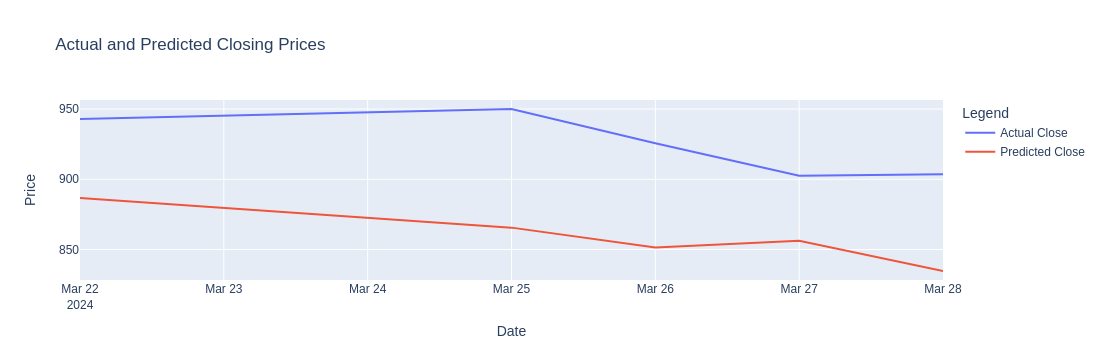

In [29]:
import plotly.graph_objs as go

# Create Plotly Scatter objects
trace1 = go.Scatter(
    x=merged_df.index,
    y=merged_df['Close'],
    mode='lines',
    name='Actual Close'
)

trace2 = go.Scatter(
    x=merged_df.index,
    y=merged_df['Predicted_Close'],
    mode='lines',
    name='Predicted Close'
)

# Create and show the combined graph
fig = go.Figure(data=[trace1, trace2])
fig.update_layout(
    title='Actual and Predicted Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend'
)

fig.show()


In [30]:
# Hata metriklerini hesaplayın
errors = merged_df['Close'] - merged_df['Predicted_Close']
mae = np.mean(np.abs(errors))
mse = np.mean(np.square(errors))
rmse = np.sqrt(mse)

print(f"MAE: {mae}") # Mean Absolute Error - MAE
print(f"MSE: {mse}") # Mean Squared Error - MSE
print(f"RMSE: {rmse}") # Root Mean Squared Error - RMSE

MAE: 66.0130591679452
MSE: 4537.440598715966
RMSE: 67.36052700740966


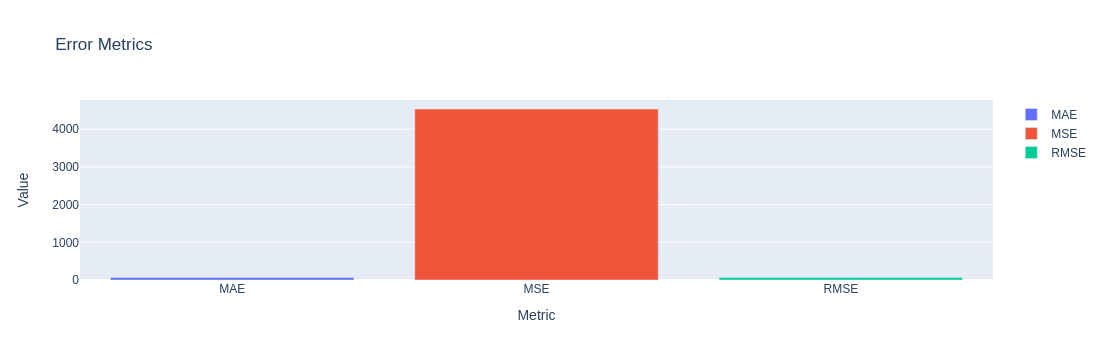

In [31]:
import plotly.graph_objs as go

# Örnek veriler
hata = {
    'Metrics': ['MAE', 'MSE', 'RMSE'],
    'Values': [mae, mse, rmse]
}
# Bar grafiği oluşturun ve efsane (legend) özelliğini aktifleştirin
traces = []
for metric, value in zip(hata['Metrics'], hata['Values']):
    traces.append(go.Bar(x=[metric], y=[value], name=metric))

fig = go.Figure(data=traces)
fig.update_layout(
    title='Error Metrics',
    xaxis_title='Metric',
    yaxis_title='Value',
    showlegend=True  # Efsaneyi göster
)

# Grafiği göster
fig.show()